In [46]:
from pymongo import MongoClient

from sklearn.cluster import KMeans
import pandas as pd


mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client['tiktokDB']
collection = db['tiktok']
collection_cluster = db['tiktok_cluster']
data = collection.find({})


In [47]:
# get data from mongodb

df = pd.DataFrame(data)
print(df.head())

cluster = KMeans(n_clusters=10)
cluster.fit(df[['views', 'engagement_total']])
df['cluster'] = cluster.labels_
# insert to tiktok_cluster
collection_cluster.insert_many(df.to_dict('records'))
print(df)



                        _id                   label  \
0  6558c3d27d99d919cd13ef22  partai amanat nasional   
1  6558c3d27d99d919cd13ef23  partai amanat nasional   
2  6558c3d27d99d919cd13ef24  partai amanat nasional   
3  6558c3d27d99d919cd13ef25  partai amanat nasional   
4  6558c3d27d99d919cd13ef26  partai amanat nasional   

                                           url_video    like  comment  \
0  https://www.tiktok.com/@putri_zulhas/video/727...   74700      920   
1  https://www.tiktok.com/@amanat_nasional/video/...  325400    13200   
2  https://www.tiktok.com/@putri_zulhas/video/729...   93700      794   
3  https://www.tiktok.com/@anakbawang619/video/72...    2118       22   
4  https://www.tiktok.com/@putri_zulhas/video/726...  133600     1942   

     views  share   save     tanggal  engagement_total  
0  2500000    498   2446  1693406580             78564  
1  3500000   6198  13700  1698207667            358498  
2  1700000    371   2700  1697375208             97565  
3 

c:\Users\user\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


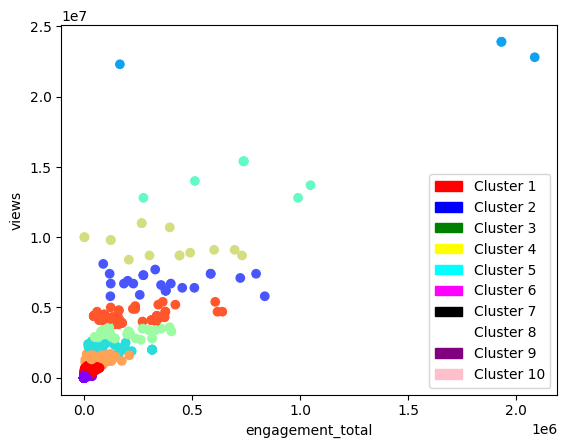

In [48]:
# visualization
import matplotlib.pyplot as plt
plt.scatter(df['engagement_total'], df['views'], c=cluster.labels_, cmap='rainbow')
plt.xlabel('engagement_total')
plt.ylabel('views')
# legend for cluster label
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Cluster 1')
blue_patch = mpatches.Patch(color='blue', label='Cluster 2')
green_patch = mpatches.Patch(color='green', label='Cluster 3')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 4')
cyan_patch = mpatches.Patch(color='cyan', label='Cluster 5')
magenta_patch = mpatches.Patch(color='magenta', label='Cluster 6')
black_patch = mpatches.Patch(color='black', label='Cluster 7')
white_patch = mpatches.Patch(color='white', label='Cluster 8')
purple_patch = mpatches.Patch(color='purple', label='Cluster 9')
pink_patch = mpatches.Patch(color='pink', label='Cluster 10')
plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch, cyan_patch, magenta_patch, black_patch, white_patch, purple_patch, pink_patch])
plt.show()


In [50]:
import json
pipeline = [
    {
        '$group': {
            '_id': {
                'cluster': '$cluster',
                'label': '$label'
            },
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$group': {
            '_id': '$_id.cluster',
            'labelCounts': {
                '$push': {
                    'label': '$_id.label',
                    'count': '$count'
                }
            }
        }
    }
]
data_cluster = collection_cluster.aggregate(pipeline)
print(json.dumps(list(data_cluster), indent=4, sort_keys=True))

[
    {
        "_id": 2,
        "labelCounts": [
            {
                "count": 1,
                "label": "partai ummat"
            },
            {
                "count": 1,
                "label": "partai garda perubahan indonesia"
            },
            {
                "count": 1,
                "label": "partai gelombang rakyat indonesia"
            },
            {
                "count": 1,
                "label": "partai persatuan indonesia"
            }
        ]
    },
    {
        "_id": 4,
        "labelCounts": [
            {
                "count": 1,
                "label": "partai demokrasi indonesia perjuangan"
            },
            {
                "count": 2,
                "label": "partai persatuan indonesia"
            },
            {
                "count": 2,
                "label": "partai solidaritas indonesia"
            },
            {
                "count": 2,
                "label": "partai garda perubahan indo